# Modelling and Deployment using MLOps 

Now that we have audio input data & corresponding labels in an array format, it is easier to consume and apply Natural language processing techniques. We can convert audio files labels into integers using label Encoding or One Hot Vector Encoding for machines to learn. The labeled dataset will help us in the neural network model output layer for predicting results. These help in training & validation datasets into nD array.
At this stage, we apply other pre-processing techniques like dropping columns, normalization, etc. to conclude our final training data for building models. Moving to the next stage of splitting the dataset into train, test, and validation is what we have been doing for other models. 
We can leverage CNN, RNN, LSTM,CTC etc. deep neural algorithms to build and train the models for speech applications like speech recognition. The model trained with the standard size few seconds audio chunk transformed into an array of n dimensions with the respective labels will result in predicting output labels for test audio input. As output labels will vary beyond binary, we are talking about building a multi-class label classification method.


In [30]:
import pandas as pd
import numpy as np
import os,sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import tensorflow as tf
from clean import Clean
from deep_learner import DeepLearn
from modeling import Modeler

In [34]:
AM_ALPHABET='ሀለሐመሠረሰቀበግዕዝተኀነአከወዐዘየደገጠጰጸፀፈፐቈኈጐኰፙፘፚauiāeəo'
EN_ALPHABET='abcdefghijklmnopqrstuvwxyz'

In [35]:
cleaner = Clean()
vocabs = cleaner.vocab(EN_ALPHABET)
char_to_num,num_to_char = vocabs

2022-06-02 04:05:54,680:logger:Successfully initialized clean class


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] (size =27)


# Deep Learning Model

**objective**: Build a Deep learning model that converts speech to text.

In [33]:
swahili_df = pd.read_csv("../data/swahili.csv")
amharic_df = pd.read_csv("../data/amharic.csv")
# swahili_df['key'] = list(range(len(swahili_df)))
# amharic_df['key'] = list(range(len(amharic_df)))

In [51]:
pre_model = Modeler()

In [52]:
swahili_preprocessed = pre_model.preprocessing_learn(swahili_df,'mfcc-1','mfcc-0')

In [57]:
amharic_preprocessed = pre_model.preprocessing_learn(amharic_df,'mfcc-2','mfcc-0')

In [59]:
train_df,val_df,test_df = amharic_preprocessed

In [48]:
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label,type='amharic'):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file=None
    if type == 'swahili':
        wavs_path='../data/swahili_train_wav/'
        wav_file_ = wav_file+".wav"
        for inner_wav_folder in os.listdir(wavs_path):
            for fetched_file in inner_wav_folder:
                if fetched_file == wav_file_:
                    file = tf.io.read_file(wavs_path + wav_file_)
    else:
        wavs_path='../data/amharic_train_wav//'
        wav_file_ = wav_file+".wav"
        file = tf.io.read_file(wavs_path + wav_file_)

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [61]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df["key"]), list(train_df["text"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(val_df["key"]), list(val_df["text"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


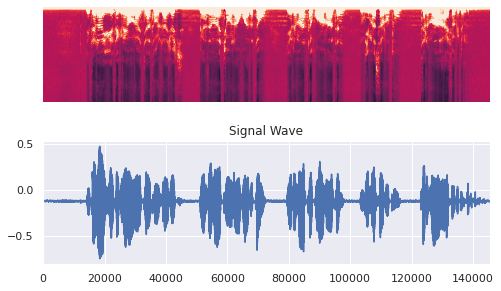

In [68]:
import matplotlib.pyplot as plt
from IPython import display
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file("../data/amharic_train_wav/" + list(train_df["key"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


In [26]:
train_df

,key,duration,rate,rmse,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc-1,...,mfcc-11,mfcc-12,mfcc-13,mfcc-14,mfcc-15,mfcc-16,mfcc-17,mfcc-18,mfcc-19,mfcc-0
0,0,3.9,44100,0.140494,0.315876,1866.409879,1589.100426,3359.724832,0.054397,"[83.27722, 99.38664, 102.47901, 90.34943, 71....",...,"[8.168702, 14.0366535, 16.038925, 15.536394, ...","[-3.862731, -4.396248, 5.0084095, 10.777882, ...","[-5.1126146, -8.593059, 0.5960377, 3.3219213,...","[7.466035, 8.751228, 11.057912, 8.758237, 9.4...","[7.371366, 6.87022, 10.244551, 11.825554, 6.3...","[-3.9841778, -6.7652984, 0.2561152, 8.012002,...","[-10.074699, -8.62624, -2.4564838, 3.956565, ...","[-9.044133, -6.4383917, -0.39757836, 2.210609...","[-5.1926327, -0.0011684299, 6.8749275, 8.6460...","[-499.7574, -478.80606, -484.01407, -501.7097..."
1,1,3.9,44100,0.162743,0.321692,1900.991630,1655.337451,3481.883645,0.049550,"[41.19271, 43.64393, 39.571014, 39.280922, 37...",...,"[12.310079, 11.866571, 14.6186, 13.844271, 15...","[9.388332, 9.306625, 11.078758, 10.565126, 13...","[6.2646713, 6.783835, 7.9363847, 7.3178806, 1...","[3.6419904, 4.6776457, 6.5209513, 5.654462, 9...","[2.104116, 3.356882, 5.659413, 4.1505423, 7.4...","[1.8616735, 3.0369122, 4.5197396, 2.1954632, ...","[2.6579711, 3.5943644, 4.0682106, 1.5907955, ...","[3.8751554, 4.5339994, 4.1353364, 2.3035893, ...","[4.78513, 5.23909, 3.1639218, 2.1374843, 3.07...","[-513.5918, -511.832, -514.46265, -514.7265, ..."
2,2,3.9,44100,0.164615,0.355232,2063.848819,1775.474533,3859.115658,0.049307,"[82.287254, 87.646355, 82.0253, 94.94374, 91....",...,"[5.2754736, 3.1030126, 13.407595, 11.497463, ...","[-3.8446255, -2.971214, -4.5158086, -15.05637...","[-10.348606, -7.0784025, -4.1666775, -4.44252...","[-6.6246963, -4.2140656, 7.8236904, 18.939777...","[3.9710789, 5.172476, 7.676926, 8.67643, 14.1...","[8.910217, 11.790334, 7.967798, 1.5910062, 2....","[1.8036795, 5.0296683, 7.0958915, 3.4036198, ...","[-5.9104943, -4.2941203, -1.3336377, -5.77136...","[-4.1684318, -3.8071477, -3.5682287, -4.74488...","[-474.19022, -459.1682, -450.55014, -418.1049..."
3,3,3.9,44100,0.168792,0.451515,1852.997999,1686.271162,3497.119321,0.048648,"[119.83493, 107.27291, 75.60173, 67.41678, 67...",...,"[6.872613, 13.56502, 21.499748, 20.410894, 19...","[1.4193982, 6.754388, 12.58844, 9.958288, 8.7...","[8.313048, 11.108404, 11.795284, 11.0210495, ...","[6.1494207, 13.033355, 11.653352, 12.482355, ...","[-0.7938506, 2.4656396, 4.9645514, 4.650465, ...","[2.9275475, 3.0828507, 6.777918, 4.701215, 4....","[1.3701015, 6.540661, 12.440676, 9.548298, 9....","[-1.563393, 1.938827, 7.003166, 6.8333797, 7....","[4.3837843, 3.7773314, 3.6287487, 6.9111385, ...","[-378.3314, -411.32068, -453.55417, -462.8506..."
4,4,3.9,44100,0.154860,0.319131,2039.119501,1727.509904,3764.721680,0.053856,"[89.52852, 70.175644, 45.881165, 45.599052, 4...",...,"[4.9950647, 8.634994, 14.272382, 12.56731, 12...","[7.4182777, 7.690419, 12.692128, 12.182736, 1...","[7.06954, 8.22206, 10.788137, 10.460276, 9.97...","[3.56195, 6.2237577, 10.590099, 9.364218, 7.9...","[2.264758, 2.9242005, 8.381964, 7.1470985, 6....","[2.5808952, 2.183845, 5.509285, 4.1491947, 4....","[2.9141243, 3.7477784, 3.8442445, 2.7395709, ...","[3.6552742, 3.716537, 1.9041413, 2.350606, 2....","[2.542642, 0.7222822, -0.16030657, 0.7033057,...","[-454.5815, -481.88647, -506.8154, -505.86523..."
5,5,3.9,44100,0.135778,0.319711,1894.964967,1746.052445,3657.568359,0.044638,"[93.67096, 105.87641, 120.79372, 113.927605, ...",...,"[9.562181, 9.880527, 5.5669446, 8.13823, 6.80...","[-12.6015415, -9.824036, -10.921469, -8.58217...","[-9.072727, -2.789328, -4.1653934, -4.451466,...","[15.360479, 17.082771, 17.751684, 20.176128, ...","[12.586064, 5.655569, 8.9193, 12.227798, 15.0...","[3.9960914, -0.9085444, -1.3349696, -3.413934...","[9.923491, 13.2172365, 12.597883, 3.8224878, ...","[9.994133, 11.891722, 12.108128, 4.8265734, 0...","[7.0713415, 5.8047085, 1.4041085, 1.0294272, ...","[-409.63712, -386.5259, -378.2063, -387.13

## LSTM Deep Learning

In [69]:
learn = DeepLearn(input_width=1, label_width=1, shift=1,epochs=5,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=['input_array'])
fft_length = 384
cleaner = Clean()
vocabs = cleaner.vocab(EN_ALPHABET)
char_to_num,num_to_char = vocabs
model = learn.build_asr_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)
# predictions = learn.model(
#     model_=model
# )

2022-06-02 04:33:41,657:logger:Successfully initialized clean class


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] (size =27)


ValueError: The name "dense_1" is used 2 times in the model. All layer names should be unique.

# Evaluation

**objective**: Evaluate your model. 

In [11]:
predictions

[[[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]]]

## CNN Deep Learning

In [19]:
model=tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])

2022-06-01 12:36:13.306843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 12:36:13.323140: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 12:36:13.446906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


In [9]:
learn = DeepLearn(input_width=1, label_width=1, shift=1,epochs=5,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=['text'])
predictions = learn.model(
    model_=model
)

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 26.0230 - mean_absolute_error: 3.9458 - val_loss: 8.4775 - val_mean_absolute_error: 2.9116
Epoch 2/5
1/1 [==============================] - 0s 132ms/step - loss: 25.9675 - mean_absolute_error: 3.9411 - val_loss: 8.4363 - val_mean_absolute_error: 2.9045
Epoch 3/5
1/1 [==============================] - 0s 138ms/step - loss: 25.9120 - mean_absolute_error: 3.9364 - val_loss: 8.3951 - val_mean_absolute_error: 2.8974
Epoch 4/5
1/1 [==============================] - 0s 120ms/step - loss: 25.8567 - mean_absolute_error: 3.9316 - val_loss: 8.3541 - val_mean_absolute_error: 2.8903
Epoch 5/5
1/1 [==============================] - 0s 118ms/step - loss: 25.8015 - mean_absolute_error: 3.9269 - val_loss: 8.3132 - val_mean_absolute_error: 2.8833


2022/06/01 10:57:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'MapDataset' object has no attribute '_batch_size'
2022-06-01 10:57:05,090:logger:Successfully executed the model


# Evaluation

**objective**: Evaluate your model. 

In [11]:
predictions

[[[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]]]

## CTC Deep Learning

In [19]:
model=tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])

2022-06-01 12:36:13.306843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 12:36:13.323140: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 12:36:13.446906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


In [9]:
learn = DeepLearn(input_width=1, label_width=1, shift=1,epochs=5,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=['text'])
predictions = learn.model(
    model_=model
)

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 26.0230 - mean_absolute_error: 3.9458 - val_loss: 8.4775 - val_mean_absolute_error: 2.9116
Epoch 2/5
1/1 [==============================] - 0s 132ms/step - loss: 25.9675 - mean_absolute_error: 3.9411 - val_loss: 8.4363 - val_mean_absolute_error: 2.9045
Epoch 3/5
1/1 [==============================] - 0s 138ms/step - loss: 25.9120 - mean_absolute_error: 3.9364 - val_loss: 8.3951 - val_mean_absolute_error: 2.8974
Epoch 4/5
1/1 [==============================] - 0s 120ms/step - loss: 25.8567 - mean_absolute_error: 3.9316 - val_loss: 8.3541 - val_mean_absolute_error: 2.8903
Epoch 5/5
1/1 [==============================] - 0s 118ms/step - loss: 25.8015 - mean_absolute_error: 3.9269 - val_loss: 8.3132 - val_mean_absolute_error: 2.8833


2022/06/01 10:57:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'MapDataset' object has no attribute '_batch_size'
2022-06-01 10:57:05,090:logger:Successfully executed the model


# Evaluation

**objective**: Evaluate your model. 

In [11]:
predictions

[[[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]]]